# Function Health & Arivale Test Mapping Notebook

This notebook provides a systematic approach to map Function Health test data with Arivale chemistries metadata. It handles exact matches, fuzzy matching, and manual mapping workflows to ensure comprehensive test mapping.

## Notebook Overview:
1. **Data Loading**: Import Function Health tests and Arivale chemistries metadata
2. **Exact Matching**: Find tests with identical names
3. **Fuzzy Matching**: Use string similarity algorithms to find potential matches
4. **Manual Review**: Review fuzzy matches and provide manual mappings
5. **Final Integration**: Combine all mappings and generate final dataset
6. **Export Results**: Save merged data and summary reports

In [1]:
# Import required libraries
import pandas as pd
from io import StringIO
from pathlib import Path
from thefuzz import process, fuzz
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles
import numpy as np

# Enable inline plotting for Jupyter
%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set default figure size
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print(f"pandas version: {pd.__version__}")
print("All libraries imported successfully.")
print("Matplotlib inline plotting enabled ✓")

pandas version: 2.2.3
All libraries imported successfully.
Matplotlib inline plotting enabled ✓


## 1. Configuration and Data Loading

Configure file paths and load the input data files.

In [2]:
# Configuration - Update these paths to point to your actual data files
fh_csv_path = Path('/procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/function_health_tests.csv')
arivale_tsv_path = Path('/procedure/data/local_data/MAPPING_ONTOLOGIES/arivale/chemistries_metadata.tsv')

# Ensure directory exists
fh_csv_path.parent.mkdir(parents=True, exist_ok=True)

print(f"  Function Health data: {fh_csv_path}")
print(f"  Arivale metadata: {arivale_tsv_path}")

  Function Health data: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/function_health_tests.csv
  Arivale metadata: /procedure/data/local_data/MAPPING_ONTOLOGIES/arivale/chemistries_metadata.tsv


In [3]:
# Load Function Health data
try:
    fh_df = pd.read_csv(fh_csv_path)
    # Keep only unique values in 'Test Name' column, concatenating the Category values for each test name replication
    # This is to handle the fact that some tests have multiple categories
    fh_df = fh_df.groupby('Test Name')['Category'].apply(lambda x: ', '.join(x.unique())).reset_index()

    print(f"✓ Function Health data loaded: {len(fh_df)} tests")
    print(f"  Columns: {', '.join(fh_df.columns)}")
    print(f"  Categories: {', '.join(fh_df['Category'].unique())}")
except FileNotFoundError:
    print(f"❌ Error: Function Health file not found at {fh_csv_path}")
    fh_df = pd.DataFrame()

print()


# Load Arivale chemistries metadata
try:
    # Read TSV file, skipping comment lines
    with open(arivale_tsv_path, 'r') as f:
        lines = [line for line in f if not line.startswith('#')]
    arivale_content = "".join(lines)
    
    # Parse the cleaned content
    arivale_df = pd.read_csv(StringIO(arivale_content), delimiter='\t')
    
    # Clean column names (remove quotes)
    arivale_df.columns = arivale_df.columns.str.strip('"')
    
    print(f"✓ Arivale metadata loaded: {len(arivale_df)} entries")
    print(f"  Columns: {', '.join(arivale_df.columns[:5])}...")
    
except FileNotFoundError:
    print(f"❌ Error: Arivale file not found at {arivale_tsv_path}")
    arivale_df = pd.DataFrame()

✓ Function Health data loaded: 264 tests
  Columns: Test Name, Category
  Categories: Heart, Blood, Metabolic, Liver, Liver, Bone Health, Kidneys, Urine, Allergies & Sensitivities, Bone Health, Heavy Metals, Environmental Toxins, Pancreas, Brain Health, Female Health, Male Health, Female Health, Autoimmunity, Urine, Nutrients, Kidneys, Immune Regulation, Stress & Aging, Biological Age, Environmental Toxins, Nutrients, Kidneys, Electrolytes, Electrolytes, Sexual Health, Kidneys, Electrolytes, Stress & Aging, Heart, Kidneys, Infections, Male Health, Heart, Immune Regulation, Female Health, Male Health, Stress & Aging, Thyroid, Nutrients, Heavy Metals, Heart, Female Health, Male Health, Nutrients, Brain Health, Nutrients, Electrolytes, Cancer Detection, Cancer Detection, Male Health, Thyroid, Thyroid, Autoimmunity

✓ Arivale metadata loaded: 128 entries
  Columns: Name, Display Name, Labcorp ID, Labcorp Name, Labcorp LOINC ID...


## 2. Data Exploration and Exact Matching

First, let's explore the data and attempt to find exact matches between test names.

In [4]:
# Display data samples
if not fh_df.empty:
    print("📊 Function Health Data Sample:")
    print(fh_df.head())
    print(f"\nTotal tests: {len(fh_df)}")
    print(f"Unique categories: {fh_df['Category'].nunique()}")

print("\n" + "="*60 + "\n")

if not arivale_df.empty:
    print("📊 Arivale Chemistries Data Sample:")
    # Select key columns for display
    display_cols = ['Name', 'Display Name', 'Quest LOINC ID']
    print(arivale_df[display_cols].head())
    print(f"\nTotal entries: {len(arivale_df)}")
    print(f"Unique Display Names: {arivale_df['Display Name'].nunique()}")

📊 Function Health Data Sample:
                          Test Name   Category
0     4q25-Atrial Fibrillation Risk      Heart
1                     9p21 Genotype      Heart
2  ABO Group and Rhesus (Rh) Factor      Blood
3                       Adiponectin  Metabolic
4              Alanine Transaminase      Liver

Total tests: 264
Unique categories: 38


📊 Arivale Chemistries Data Sample:
                   Name          Display Name Quest LOINC ID
0             A/G RATIO             A/G ratio         1759-0
1    ADIPONECTIN, SERUM           Adiponectin            NaN
2           ALAT (SGPT)  Alanine Transaminase         1742-6
3               ALBUMIN               Albumin         1751-7
4  ALKALINE PHOSPHATASE  Alkaline Phosphatase         6768-6

Total entries: 128
Unique Display Names: 128


In [5]:
# Attempt exact matching
print("🔍 Searching for exact matches...")

if not fh_df.empty and not arivale_df.empty and 'Test Name' in fh_df.columns and 'Display Name' in arivale_df.columns:
    # Try exact merge on Display Name
    exact_merge_df = pd.merge(
        fh_df, 
        arivale_df, 
        left_on='Test Name', 
        right_on='Display Name', 
        how='inner'
    )
    
    print(f"\n✓ Found {len(exact_merge_df)} exact matches")
    
    if not exact_merge_df.empty:
        print("\n📋 Exact Matches:")
        print(exact_merge_df[['Test Name', 'Category', 'Display Name', 'Quest LOINC ID']].to_string(index=False))
    else:
        print("\n⚠️  No exact matches found. Will proceed with fuzzy matching.")
else:
    print("❌ Cannot perform exact matching - missing required columns")
    exact_merge_df = pd.DataFrame()

🔍 Searching for exact matches...

✓ Found 39 exact matches

📋 Exact Matches:
             Test Name                           Category           Display Name Quest LOINC ID
           Adiponectin                          Metabolic            Adiponectin            NaN
  Alanine Transaminase                              Liver   Alanine Transaminase         1742-6
               Albumin                 Liver, Bone Health                Albumin         1751-7
  Alkaline Phosphatase                              Liver   Alkaline Phosphatase         6768-6
               Arsenic Heavy Metals, Environmental Toxins                Arsenic         5583-0
             Basophils                  Immune Regulation              Basophils          706-2
               Calcium   Nutrients, Kidneys, Electrolytes                Calcium        17861-6
        Carbon Dioxide                       Electrolytes         Carbon Dioxide         2028-9
              Chloride              Kidneys, Electrolytes  

## 3. Fuzzy Matching Setup

Configure fuzzy matching parameters and helper functions.

In [6]:
# Extract unique test names for matching
if not fh_df.empty and 'Test Name' in fh_df.columns:
    fh_test_names = fh_df['Test Name'].dropna().unique().tolist()
    print(f"📋 Function Health: {len(fh_test_names)} unique test names")
else:
    fh_test_names = []

if not arivale_df.empty and 'Display Name' in arivale_df.columns:
    arivale_quest_names = arivale_df['Display Name'].dropna().unique().tolist()
    print(f"📋 Arivale: {len(arivale_quest_names)} unique Display Names")
else:
    arivale_quest_names = []

# Fuzzy matching configuration
FUZZY_THRESHOLD = 80  # Minimum score to consider a match (0-100)
TOP_N_MATCHES = 3     # Number of top matches to return for review

print(f"\n⚙️  Fuzzy Matching Settings:")
print(f"   - Minimum similarity score: {FUZZY_THRESHOLD}%")
print(f"   - Top matches to show: {TOP_N_MATCHES}")

📋 Function Health: 264 unique test names
📋 Arivale: 128 unique Display Names

⚙️  Fuzzy Matching Settings:
   - Minimum similarity score: 80%
   - Top matches to show: 3


In [7]:
def get_fuzzy_matches(test_name, candidate_names, threshold=FUZZY_THRESHOLD):
    """
    Find fuzzy matches for a given test name from a list of candidate names.
    Uses multiple matching algorithms for better coverage.
    
    Returns a list of tuples: (matched_name, score, ratio_type)
    """
    if not test_name or not candidate_names:
        return []
    
    matches = []
    
    # Try different fuzzy matching algorithms
    algorithms = [
        ('simple_ratio', fuzz.ratio),
        ('token_set_ratio', fuzz.token_set_ratio),
        ('partial_ratio', fuzz.partial_ratio)
    ]
    
    for algo_name, scorer in algorithms:
        results = process.extract(test_name, candidate_names, scorer=scorer, limit=TOP_N_MATCHES)
        for match, score in results:
            if score >= threshold and match not in [m[0] for m in matches]:
                matches.append((match, score, algo_name))
    
    # Sort by score descending and limit to TOP_N_MATCHES
    matches.sort(key=lambda x: x[1], reverse=True)
    return matches[:TOP_N_MATCHES]

print("✓ Fuzzy matching function defined")

✓ Fuzzy matching function defined


## 4. Perform Fuzzy Matching

Execute fuzzy matching for all Function Health test names.

In [8]:
# Perform fuzzy matching (excluding already matched items)
fuzzy_results = []

# Track which items have been matched in exact matching
matched_fh_tests = set()
matched_arivale_names = set()

if 'exact_merge_df' in locals() and not exact_merge_df.empty:
    matched_fh_tests = set(exact_merge_df['Test Name'].unique())
    matched_arivale_names = set(exact_merge_df['Display Name'].unique())
    print(f"📌 Excluding {len(matched_fh_tests)} Function Health tests already matched exactly")
    print(f"📌 Excluding {len(matched_arivale_names)} Arivale entries already matched exactly\n")

# Filter out already matched items
remaining_fh_tests = [test for test in fh_test_names if test not in matched_fh_tests]
remaining_arivale_names = [name for name in arivale_quest_names if name not in matched_arivale_names]

if remaining_fh_tests and remaining_arivale_names:
    print(f"🔍 Performing fuzzy matching for {len(remaining_fh_tests)} remaining Function Health tests...")
    print(f"   Against {len(remaining_arivale_names)} remaining Arivale entries\n")
    
    for fh_test in remaining_fh_tests:
        matches = get_fuzzy_matches(fh_test, remaining_arivale_names)
        
        if matches:
            fuzzy_results.append({
                'FH_Test_Name': fh_test,
                'Best_Match': matches[0][0],
                'Best_Score': matches[0][1],
                'Match_Type': matches[0][2],
                'All_Matches': matches
            })
            
            # Show matches for review
            print(f"📌 '{fh_test}'")
            for match, score, match_type in matches:
                confidence = "🟢" if score >= 95 else "🟡" if score >= 85 else "🔴"
                print(f"   {confidence} '{match}' (score: {score}%, type: {match_type})")
            print()
    
    print(f"\n✓ Fuzzy matching complete: {len(fuzzy_results)} / {len(remaining_fh_tests)} tests have potential matches")
    
    # Convert to DataFrame
    fuzzy_df = pd.DataFrame(fuzzy_results)
else:
    print("❌ No remaining items to fuzzy match after exact matching")
    fuzzy_df = pd.DataFrame()

📌 Excluding 39 Function Health tests already matched exactly
📌 Excluding 39 Arivale entries already matched exactly

🔍 Performing fuzzy matching for 225 remaining Function Health tests...
   Against 89 remaining Arivale entries

📌 'Alpha-1 Globulin'
   🔴 'PAI-1' (score: 80%, type: partial_ratio)

📌 'Apolipoprotein A1'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein B (ApoB)'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein B/Apolipoprotein A1 Ratio'
   🟢 'Protein' (score: 100%, type: partial_ratio)
   🔴 'A/G ratio' (score: 82%, type: partial_ratio)

📌 'Apolipoprotein C1'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein C2'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein C3'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein C4'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Apolipoprotein E (ApoE)'
   🟢 'Protein' (score: 100%, type: partial_ratio)

📌 'Arachidonic Acid/EPA Ratio'
 

## 5. Analyze Fuzzy Matching Results

Review the fuzzy matching results and categorize by confidence level.

In [9]:
# Analyze fuzzy matching results
if not fuzzy_df.empty:
    # Categorize by confidence level
    high_confidence = fuzzy_df[fuzzy_df['Best_Score'] >= 95]
    medium_confidence = fuzzy_df[(fuzzy_df['Best_Score'] >= 85) & (fuzzy_df['Best_Score'] < 95)]
    low_confidence = fuzzy_df[fuzzy_df['Best_Score'] < 85]
    
    print("📊 Fuzzy Matching Summary:")
    print(f"   🟢 High confidence (≥95%): {len(high_confidence)} matches")
    print(f"   🟡 Medium confidence (85-94%): {len(medium_confidence)} matches")
    print(f"   🔴 Low confidence (<85%): {len(low_confidence)} matches")
    
    # Show confidence breakdown
    if len(high_confidence) > 0:
        print("\n🟢 High Confidence Matches:")
        print(high_confidence[['FH_Test_Name', 'Best_Match', 'Best_Score']].to_string(index=False))
    
    if len(medium_confidence) > 0:
        print("\n🟡 Medium Confidence Matches (review recommended):")
        print(medium_confidence[['FH_Test_Name', 'Best_Match', 'Best_Score']].to_string(index=False))
    
    # Save fuzzy matches for review
    fuzzy_review_path = fh_csv_path.parent / 'fuzzy_matches_for_review.csv'
    fuzzy_df.to_csv(fuzzy_review_path, index=False)
    print(f"\n💾 Fuzzy matches saved to: {fuzzy_review_path}")
else:
    print("❌ No fuzzy matches to analyze")

📊 Fuzzy Matching Summary:
   🟢 High confidence (≥95%): 37 matches
   🟡 Medium confidence (85-94%): 17 matches
   🔴 Low confidence (<85%): 18 matches

🟢 High Confidence Matches:
                                    FH_Test_Name                  Best_Match  Best_Score
                               Apolipoprotein A1                     Protein         100
                         Apolipoprotein B (ApoB)                     Protein         100
        Apolipoprotein B/Apolipoprotein A1 Ratio                     Protein         100
                               Apolipoprotein C1                     Protein         100
                               Apolipoprotein C2                     Protein         100
                               Apolipoprotein C3                     Protein         100
                               Apolipoprotein C4                     Protein         100
                         Apolipoprotein E (ApoE)                     Protein         100
                      

## 6. Manual Mapping Support

Set up infrastructure for manual mapping corrections and additions.

In [10]:
# Manual mapping configuration
manual_mapping_path = fh_csv_path.parent / 'manual_mappings.csv'

# Create or load manual mapping file
if not manual_mapping_path.exists():
    print("📝 Creating manual mapping template...")
    
    # Create a template with headers
    manual_template = pd.DataFrame({
        'FH_Test_Name': ['Example: Cholesterol Total', 'Example: HbA1c Test'],
        'Arivale_Quest_Name': ['CHOLESTEROL, TOTAL', 'HEMOGLOBIN A1C'],
        'Confidence': ['Manual', 'Manual'],
        'Notes': ['User verified', 'Alternative name for Hemoglobin A1c']
    })
    
    manual_template.to_csv(manual_mapping_path, index=False)
    print(f"✓ Template created at: {manual_mapping_path}")
    print("\n📋 Template Preview:")
    print(manual_template.to_string(index=False))
    print("\n⚠️  Edit this file to add your manual mappings, then re-run this notebook.")
    manual_mappings_df = pd.DataFrame()  # Empty for now
else:
    # Load existing manual mappings
    try:
        manual_mappings_df = pd.read_csv(manual_mapping_path)
        # Filter out example rows
        manual_mappings_df = manual_mappings_df[~manual_mappings_df['FH_Test_Name'].str.startswith('Example:')]
        
        if len(manual_mappings_df) > 0:
            print(f"✓ Loaded {len(manual_mappings_df)} manual mappings")
            print("\n📋 Manual Mappings:")
            print(manual_mappings_df.to_string(index=False))
        else:
            print("⚠️  No manual mappings found (only example entries)")
    except Exception as e:
        print(f"❌ Error loading manual mappings: {e}")
        manual_mappings_df = pd.DataFrame()

print(fh_csv_path.parent / 'manual_mappings.csv')

⚠️  No manual mappings found (only example entries)
/procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/manual_mappings.csv


## 7. Combine All Mappings

Merge exact matches, fuzzy matches, and manual mappings into a single comprehensive mapping.

In [11]:
# Combine all mappings (ensuring no duplicates)
all_mappings = []
used_fh_tests = set()
used_arivale_names = set()

# 1. Add exact matches first (highest priority)
if 'exact_merge_df' in locals() and not exact_merge_df.empty:
    for _, row in exact_merge_df.iterrows():
        all_mappings.append({
            'FH_Test_Name': row['Test Name'],
            'Matched_Display_Name': row['Display Name'],
            'Match_Type': 'Exact',
            'Match_Score': 100
        })
        used_fh_tests.add(row['Test Name'])
        used_arivale_names.add(row['Display Name'])
    print(f"✓ Added {len(exact_merge_df)} exact matches")
    print(f"  Used FH tests: {len(used_fh_tests)}, Used Arivale entries: {len(used_arivale_names)}")

# 2. Add high-confidence fuzzy matches (only if not already matched)
if not fuzzy_df.empty:
    high_conf_fuzzy = fuzzy_df[fuzzy_df['Best_Score'] >= 95]
    added_fuzzy = 0
    
    for _, row in high_conf_fuzzy.iterrows():
        # Check if either the FH test or Arivale name is already used
        if row['FH_Test_Name'] not in used_fh_tests and row['Best_Match'] not in used_arivale_names:
            all_mappings.append({
                'FH_Test_Name': row['FH_Test_Name'],
                'Matched_Display_Name': row['Best_Match'],
                'Match_Type': f'Fuzzy ({row["Match_Type"]})',
                'Match_Score': row['Best_Score']
            })
            used_fh_tests.add(row['FH_Test_Name'])
            used_arivale_names.add(row['Best_Match'])
            added_fuzzy += 1
    
    print(f"✓ Added {added_fuzzy} high-confidence fuzzy matches (out of {len(high_conf_fuzzy)} candidates)")
    print(f"  Total used FH tests: {len(used_fh_tests)}, Total used Arivale entries: {len(used_arivale_names)}")

# 3. Add manual mappings (these override any existing mappings)
if not manual_mappings_df.empty:
    added_manual = 0
    overridden = 0
    
    for _, row in manual_mappings_df.iterrows():
        fh_test = row['FH_Test_Name']
        arivale_name = row['Arivale_Quest_Name']
        
        # Check if we need to remove existing mappings
        if fh_test in used_fh_tests or arivale_name in used_arivale_names:
            # Remove any existing mapping for this FH test or Arivale name
            all_mappings = [m for m in all_mappings if 
                          m['FH_Test_Name'] != fh_test and 
                          m['Matched_Display_Name'] != arivale_name]
            overridden += 1
            
            # Update the used sets
            used_fh_tests = {m['FH_Test_Name'] for m in all_mappings}
            used_arivale_names = {m['Matched_Display_Name'] for m in all_mappings}
        
        # Add the manual mapping
        all_mappings.append({
            'FH_Test_Name': fh_test,
            'Matched_Display_Name': arivale_name,
            'Match_Type': 'Manual',
            'Match_Score': 100
        })
        used_fh_tests.add(fh_test)
        used_arivale_names.add(arivale_name)
        added_manual += 1
    
    print(f"✓ Added {added_manual} manual mappings ({overridden} overriding existing matches)")
    print(f"  Final used FH tests: {len(used_fh_tests)}, Final used Arivale entries: {len(used_arivale_names)}")

# Create mapping DataFrame
if all_mappings:
    mapping_df = pd.DataFrame(all_mappings)
    print(f"\n📊 Total unique mappings created: {len(mapping_df)}")
    print("\nMapping summary by type:")
    print(mapping_df['Match_Type'].value_counts())
    
    # Verify uniqueness
    assert len(mapping_df['FH_Test_Name'].unique()) == len(mapping_df), "Duplicate FH tests found!"
    assert len(mapping_df['Matched_Display_Name'].unique()) == len(mapping_df), "Duplicate Arivale entries found!"
    print("\n✓ Verified: Each test and entry is mapped at most once")
else:
    print("⚠️  No mappings were created")
    mapping_df = pd.DataFrame()

✓ Added 39 exact matches
  Used FH tests: 39, Used Arivale entries: 39
✓ Added 22 high-confidence fuzzy matches (out of 37 candidates)
  Total used FH tests: 61, Total used Arivale entries: 61

📊 Total unique mappings created: 61

Mapping summary by type:
Match_Type
Exact                      39
Fuzzy (token_set_ratio)    11
Fuzzy (simple_ratio)        9
Fuzzy (partial_ratio)       2
Name: count, dtype: int64

✓ Verified: Each test and entry is mapped at most once


## 8. Create Final Merged Dataset

Join all mapping information with the original data to create the final comprehensive dataset.

In [12]:
# Create the final merged dataset with outer join
if not mapping_df.empty:
    # Start with Function Health data
    final_df = fh_df.copy()
    
    # Add mapping information (left join to preserve all FH tests)
    final_df = final_df.merge(
        mapping_df, 
        left_on='Test Name', 
        right_on='FH_Test_Name', 
        how='left'
    )
    
    # Use the already tracked matched Arivale names from mapping combination
    if 'used_arivale_names' in locals():
        # This is more accurate as it includes all matched names from all sources
        matched_arivale_names = used_arivale_names
    else:
        # Fallback to extracting from final_df
        matched_arivale_names = set(final_df['Matched_Display_Name'].dropna().unique())
    
    # Find Arivale entries that weren't matched
    unmatched_arivale = arivale_df[~arivale_df['Display Name'].isin(matched_arivale_names)].copy()
    
    # Add Arivale metadata for matched tests
    if 'Matched_Display_Name' in final_df.columns and not arivale_df.empty:
        # Select key Arivale columns to merge
        arivale_merge_cols = ['Display Name', 'Name', 'Quest Name', 'Quest ID', 
                             'Quest LOINC ID', 'Labcorp Name', 'Labcorp LOINC ID']
        arivale_merge_cols = [col for col in arivale_merge_cols if col in arivale_df.columns]
        
        final_df = final_df.merge(
            arivale_df[arivale_merge_cols], 
            left_on='Matched_Display_Name', 
            right_on='Display Name', 
            how='left',
            suffixes=('_FH', '_Arivale')
        )
    
    # Prepare unmatched Arivale entries with consistent columns
    if len(unmatched_arivale) > 0:
        # Add empty FH columns to unmatched Arivale entries
        for col in ['Test Name', 'Category', 'FH_Test_Name', 'Matched_Display_Name', 
                    'Match_Type', 'Match_Score']:
            if col not in unmatched_arivale.columns:
                unmatched_arivale[col] = None
        
        # Append unmatched Arivale entries to final dataframe
        final_df = pd.concat([final_df, unmatched_arivale], ignore_index=True)
    
    # Calculate statistics
    total_matches = len(mapping_df)
    unmatched_fh_count = (final_df['Test Name'].notna() & final_df['Matched_Display_Name'].isna()).sum()
    unmatched_ar_count = len(unmatched_arivale)
    
    print(f"✓ Final dataset created (outer join with unique mappings)")
    print(f"  Shape: {final_df.shape}")
    print(f"\n📊 Mapping Statistics:")
    print(f"  Total unique matches: {total_matches}")
    print(f"  Function Health tests: {len(fh_df)} total")
    print(f"    - Matched: {total_matches} ({total_matches/len(fh_df)*100:.1f}%)")
    print(f"    - Unmatched: {unmatched_fh_count} ({unmatched_fh_count/len(fh_df)*100:.1f}%)")
    print(f"  Arivale entries: {len(arivale_df)} total")
    print(f"    - Matched: {total_matches} ({total_matches/len(arivale_df)*100:.1f}%)")
    print(f"    - Unmatched: {unmatched_ar_count} ({unmatched_ar_count/len(arivale_df)*100:.1f}%)")
    
    # Display samples
    if final_df['Matched_Display_Name'].notna().any():
        print("\n📋 Sample of Matched Tests:")
        display_cols = ['Test Name', 'Category', 'Matched_Display_Name', 'Match_Type', 
                       'Match_Score', 'Quest LOINC ID']
        available_cols = [col for col in display_cols if col in final_df.columns]
        print(final_df[final_df['Matched_Display_Name'].notna()][available_cols].head().to_string(index=False))
    
    # Show unmatched FH tests
    unmatched_fh = final_df[final_df['Test Name'].notna() & final_df['Matched_Display_Name'].isna()]
    if len(unmatched_fh) > 0:
        print(f"\n⚠️  Unmatched Function Health Tests ({len(unmatched_fh)}):")
        for test in unmatched_fh['Test Name'].head(10).values:
            print(f"   - {test}")
        if len(unmatched_fh) > 10:
            print(f"   ... and {len(unmatched_fh) - 10} more")
    
    # Show unmatched Arivale entries
    unmatched_ar = final_df[final_df['Display Name'].notna() & final_df['Test Name'].isna()]
    if len(unmatched_ar) > 0:
        print(f"\n⚠️  Unmatched Arivale Entries ({len(unmatched_ar)}):")
        for test in unmatched_ar['Display Name'].head(10).values:
            print(f"   - {test}")
        if len(unmatched_ar) > 10:
            print(f"   ... and {len(unmatched_ar) - 10} more")
else:
    print("⚠️  No mappings available - using original Function Health data only")
    final_df = fh_df.copy()

✓ Final dataset created (outer join with unique mappings)
  Shape: (331, 15)

📊 Mapping Statistics:
  Total unique matches: 61
  Function Health tests: 264 total
    - Matched: 61 (23.1%)
    - Unmatched: 203 (76.9%)
  Arivale entries: 128 total
    - Matched: 61 (47.7%)
    - Unmatched: 67 (52.3%)

📋 Sample of Matched Tests:
           Test Name           Category Matched_Display_Name            Match_Type  Match_Score Quest LOINC ID
         Adiponectin          Metabolic          Adiponectin                 Exact        100.0            NaN
Alanine Transaminase              Liver Alanine Transaminase                 Exact        100.0         1742-6
             Albumin Liver, Bone Health              Albumin                 Exact        100.0         1751-7
Alkaline Phosphatase              Liver Alkaline Phosphatase                 Exact        100.0         6768-6
   Apolipoprotein A1              Heart              Protein Fuzzy (partial_ratio)        100.0            NaN

⚠️  U

## 9. Export Results

Save the final merged dataset and generate summary reports.

In [13]:
# Save the final merged dataset
output_path = fh_csv_path.parent / 'function_health_arivale_merged_outer.csv'

if not final_df.empty:
    # Select columns for output
    output_columns = []
    
    # Function Health columns - only include columns that exist
    fh_columns = ['Category', 'Test Name', 'Notes']
    available_fh_columns = [col for col in fh_columns if col in final_df.columns]
    output_columns.extend(available_fh_columns)
    
    # Mapping information
    mapping_columns = ['Matched_Display_Name', 'Match_Type', 'Match_Score']
    output_columns.extend([col for col in mapping_columns if col in final_df.columns])
    
    # Key Arivale columns
    arivale_columns = ['Name', 'Display Name', 'Quest Name', 'Quest ID', 'Quest LOINC ID', 
                      'Labcorp Name', 'Labcorp LOINC ID']
    output_columns.extend([col for col in arivale_columns if col in final_df.columns])
    
    # Remove duplicates while preserving order
    output_columns = list(dict.fromkeys(output_columns))
    
    # Save the final dataset
    final_output_df = final_df[output_columns].copy()
    
    # Sort the dataframe to group matched entries first, then unmatched FH, then unmatched Arivale
    final_output_df['sort_key'] = final_output_df.apply(
        lambda row: 0 if pd.notna(row.get('Matched_Display_Name')) else 
                   1 if pd.notna(row.get('Test Name')) else 2, axis=1
    )
    final_output_df = final_output_df.sort_values('sort_key').drop('sort_key', axis=1)
    
    final_output_df.to_csv(output_path, index=False)
    print(f"💾 Final merged data (outer join) saved to: {output_path}")
    print(f"   Rows: {len(final_output_df)}, Columns: {len(output_columns)}")
    
    # Save unmatched Function Health tests separately
    if 'Test Name' in final_df.columns and 'Matched_Display_Name' in final_df.columns:
        unmatched_fh_tests = final_df[
            final_df['Test Name'].notna() & 
            final_df['Matched_Display_Name'].isna()
        ]
        if len(unmatched_fh_tests) > 0:
            unmatched_fh_path = fh_csv_path.parent / 'unmatched_function_health_tests.csv'
            # Only select columns that exist
            unmatched_columns = ['Category', 'Test Name']
            if 'Notes' in unmatched_fh_tests.columns:
                unmatched_columns.append('Notes')
            unmatched_fh_tests[unmatched_columns].to_csv(unmatched_fh_path, index=False)
            print(f"💾 Unmatched Function Health tests saved to: {unmatched_fh_path}")
    
    # Save unmatched Arivale entries separately
    if 'Display Name' in final_df.columns and 'Test Name' in final_df.columns:
        unmatched_ar_tests = final_df[
            final_df['Display Name'].notna() & 
            final_df['Test Name'].isna()
        ]
        if len(unmatched_ar_tests) > 0:
            unmatched_ar_path = fh_csv_path.parent / 'unmatched_arivale_entries.csv'
            # Select relevant Arivale columns
            ar_columns = ['Name', 'Display Name', 'Quest Name', 'Quest ID', 'Quest LOINC ID', 
                         'Labcorp Name', 'Labcorp LOINC ID']
            available_ar_columns = [col for col in ar_columns if col in unmatched_ar_tests.columns]
            unmatched_ar_tests[available_ar_columns].to_csv(unmatched_ar_path, index=False)
            print(f"💾 Unmatched Arivale entries saved to: {unmatched_ar_path}")
else:
    print("❌ No data to save")

💾 Final merged data (outer join) saved to: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/function_health_arivale_merged_outer.csv
   Rows: 331, Columns: 12
💾 Unmatched Function Health tests saved to: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/unmatched_function_health_tests.csv
💾 Unmatched Arivale entries saved to: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/unmatched_arivale_entries.csv


In [14]:
# Generate summary report
summary_path = fh_csv_path.parent / 'mapping_summary_report.txt'

with open(summary_path, 'w') as f:
    f.write("Function Health to Arivale Test Mapping Summary Report (Outer Join)\n")
    f.write("="*70 + "\n")
    f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Input Files:\n")
    f.write(f"- Function Health: {fh_csv_path}\n")
    f.write(f"- Arivale Metadata: {arivale_tsv_path}\n\n")
    
    f.write("Data Summary:\n")
    f.write(f"- Total Function Health tests: {len(fh_df) if 'fh_df' in locals() else 0}\n")
    f.write(f"- Total Arivale entries: {len(arivale_df) if 'arivale_df' in locals() else 0}\n\n")
    
    if 'final_df' in locals():
        # Calculate statistics
        matched_count = final_df['Matched_Display_Name'].notna().sum()
        unmatched_fh_count = (final_df['Test Name'].notna() & final_df['Matched_Display_Name'].isna()).sum()
        unmatched_ar_count = (final_df['Display Name'].notna() & final_df['Test Name'].isna()).sum()
        
        f.write("Mapping Results:\n")
        f.write(f"- Successfully matched: {matched_count} tests\n")
        f.write(f"- Unmatched Function Health tests: {unmatched_fh_count}\n")
        f.write(f"- Unmatched Arivale entries: {unmatched_ar_count}\n")
        f.write(f"- Total rows in output: {len(final_df)}\n\n")
        
        # Match rate calculations
        if len(fh_df) > 0:
            fh_match_rate = matched_count / len(fh_df) * 100
            f.write(f"Function Health match rate: {fh_match_rate:.1f}%\n")
        if len(arivale_df) > 0:
            ar_match_rate = matched_count / len(arivale_df) * 100
            f.write(f"Arivale match rate: {ar_match_rate:.1f}%\n")
        f.write("\n")
        
        if 'Match_Type' in final_df.columns:
            f.write("Matches by Type:\n")
            match_counts = final_df[final_df['Match_Type'].notna()]['Match_Type'].value_counts()
            for match_type, count in match_counts.items():
                f.write(f"- {match_type}: {count}\n")
            f.write("\n")
    
        # List some unmatched Function Health tests
        if unmatched_fh_count > 0:
            unmatched_fh = final_df[final_df['Test Name'].notna() & final_df['Matched_Display_Name'].isna()]
            f.write(f"Sample Unmatched Function Health Tests (showing first 20 of {unmatched_fh_count}):\n")
            for i, (_, row) in enumerate(unmatched_fh.head(20).iterrows()):
                f.write(f"- [{row['Category']}] {row['Test Name']}\n")
            if unmatched_fh_count > 20:
                f.write(f"... and {unmatched_fh_count - 20} more\n")
            f.write("\n")
        
        # List some unmatched Arivale entries
        if unmatched_ar_count > 0:
            unmatched_ar = final_df[final_df['Display Name'].notna() & final_df['Test Name'].isna()]
            f.write(f"Sample Unmatched Arivale Entries (showing first 20 of {unmatched_ar_count}):\n")
            for i, (_, row) in enumerate(unmatched_ar.head(20).iterrows()):
                f.write(f"- {row['Display Name']} (Quest ID: {row.get('Quest ID', 'N/A')})\n")
            if unmatched_ar_count > 20:
                f.write(f"... and {unmatched_ar_count - 20} more\n")
    
    f.write("\nOutput Files:\n")
    f.write(f"- Merged dataset (outer join): {output_path if 'output_path' in locals() else 'Not generated'}\n")
    f.write(f"- This report: {summary_path}\n")
    f.write(f"- Fuzzy matches for review: {fuzzy_review_path if 'fuzzy_review_path' in locals() else 'Not generated'}\n")
    f.write(f"- Manual mapping template: {manual_mapping_path if 'manual_mapping_path' in locals() else 'Not generated'}\n")
    f.write(f"- Unmatched Function Health tests: {unmatched_fh_path if 'unmatched_fh_path' in locals() else 'Not generated'}\n")
    f.write(f"- Unmatched Arivale entries: {unmatched_ar_path if 'unmatched_ar_path' in locals() else 'Not generated'}\n")

print(f"📄 Summary report saved to: {summary_path}")
print("\n✅ Notebook execution complete with outer join!")

📄 Summary report saved to: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health/mapping_summary_report.txt

✅ Notebook execution complete with outer join!


In [15]:
# Check uniqueness of Test Name values (excluding NaN values from unmatched Arivale entries)
test_name_values = final_df['Test Name'].dropna()
if test_name_values.is_unique:
    print("✅ Test Name values are unique (excluding NaN from unmatched Arivale entries)")
else:
    print("❌ Duplicate Test Name values found!")
    duplicates = final_df[final_df['Test Name'].notna() & final_df.duplicated('Test Name', keep=False)]
    if len(duplicates) > 0:
        print(f"Found {len(duplicates)} duplicate rows:")
        print(duplicates[['Test Name', 'Category', 'Matched_Display_Name']].to_string())

# Also verify that the mapping is 1:1
print("\n📊 Verifying 1:1 mapping constraints:")
matched_rows = final_df[final_df['Matched_Display_Name'].notna()]
if len(matched_rows) > 0:
    unique_fh = matched_rows['Test Name'].nunique()
    unique_ar = matched_rows['Matched_Display_Name'].nunique()
    total_matches = len(matched_rows)
    
    if unique_fh == unique_ar == total_matches:
        print(f"✅ Perfect 1:1 mapping verified: {total_matches} unique matches")
    else:
        print(f"❌ Mapping issue detected:")
        print(f"   Matched rows: {total_matches}")
        print(f"   Unique FH tests: {unique_fh}")
        print(f"   Unique Arivale entries: {unique_ar}")

✅ Test Name values are unique (excluding NaN from unmatched Arivale entries)

📊 Verifying 1:1 mapping constraints:
✅ Perfect 1:1 mapping verified: 61 unique matches


## 10. Visualizations

Generate visualizations to help stakeholders understand the mapping results.

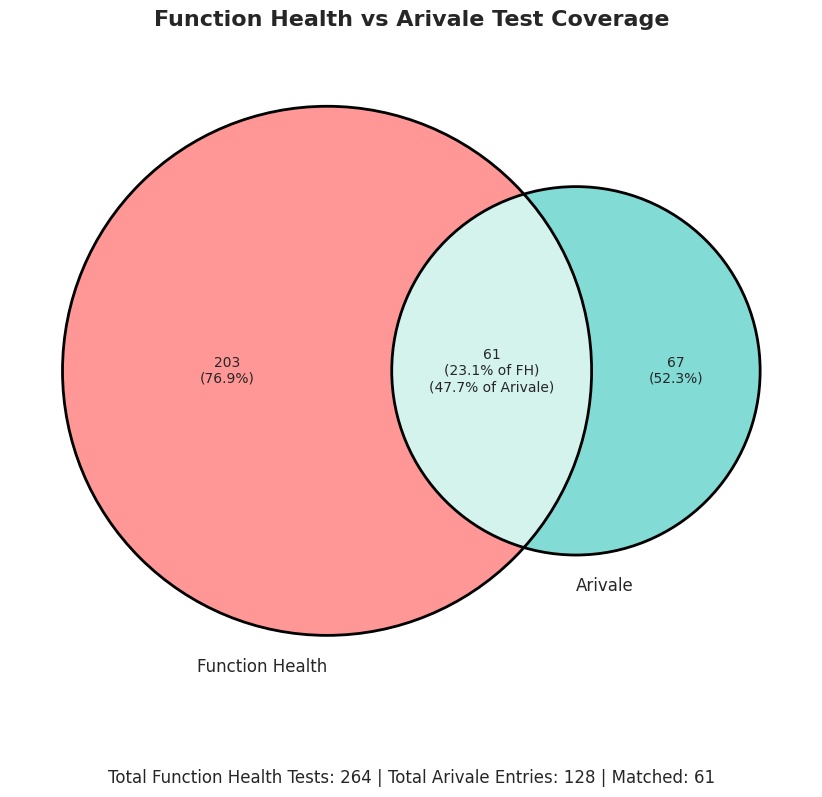


📊 Overlap Summary:
   - Function Health only: 203 tests (76.9%)
   - Arivale only: 67 entries (52.3%)
   - Matched (overlap): 61 tests


In [16]:
# Create Venn Diagram showing overlap between Function Health and Arivale tests
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate set sizes
fh_total = len(fh_df)
arivale_total = len(arivale_df)
matched_count = len(mapping_df) if 'mapping_df' in locals() else 0

# Create the Venn diagram
venn = venn2(subsets=(fh_total - matched_count, arivale_total - matched_count, matched_count), 
              set_labels=('Function Health', 'Arivale'),
              ax=ax)

# Customize the Venn diagram
venn2_circles(subsets=(fh_total - matched_count, arivale_total - matched_count, matched_count), 
              linewidth=2, ax=ax)

# Add percentages to the labels
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text(f'{fh_total - matched_count}\n({(fh_total - matched_count)/fh_total*100:.1f}%)')
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text(f'{arivale_total - matched_count}\n({(arivale_total - matched_count)/arivale_total*100:.1f}%)')
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text(f'{matched_count}\n({matched_count/fh_total*100:.1f}% of FH)\n({matched_count/arivale_total*100:.1f}% of Arivale)')

# Customize colors
if venn.get_patch_by_id('10'):
    venn.get_patch_by_id('10').set_color('#FF6B6B')
    venn.get_patch_by_id('10').set_alpha(0.7)
if venn.get_patch_by_id('01'):
    venn.get_patch_by_id('01').set_color('#4ECDC4')
    venn.get_patch_by_id('01').set_alpha(0.7)
if venn.get_patch_by_id('11'):
    venn.get_patch_by_id('11').set_color('#95E1D3')

plt.title('Function Health vs Arivale Test Coverage', fontsize=16, fontweight='bold', pad=20)
plt.text(0.5, -0.15, f'Total Function Health Tests: {fh_total} | Total Arivale Entries: {arivale_total} | Matched: {matched_count}', 
         ha='center', transform=ax.transAxes, fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n📊 Overlap Summary:")
print(f"   - Function Health only: {fh_total - matched_count} tests ({(fh_total - matched_count)/fh_total*100:.1f}%)")
print(f"   - Arivale only: {arivale_total - matched_count} entries ({(arivale_total - matched_count)/arivale_total*100:.1f}%)")
print(f"   - Matched (overlap): {matched_count} tests")

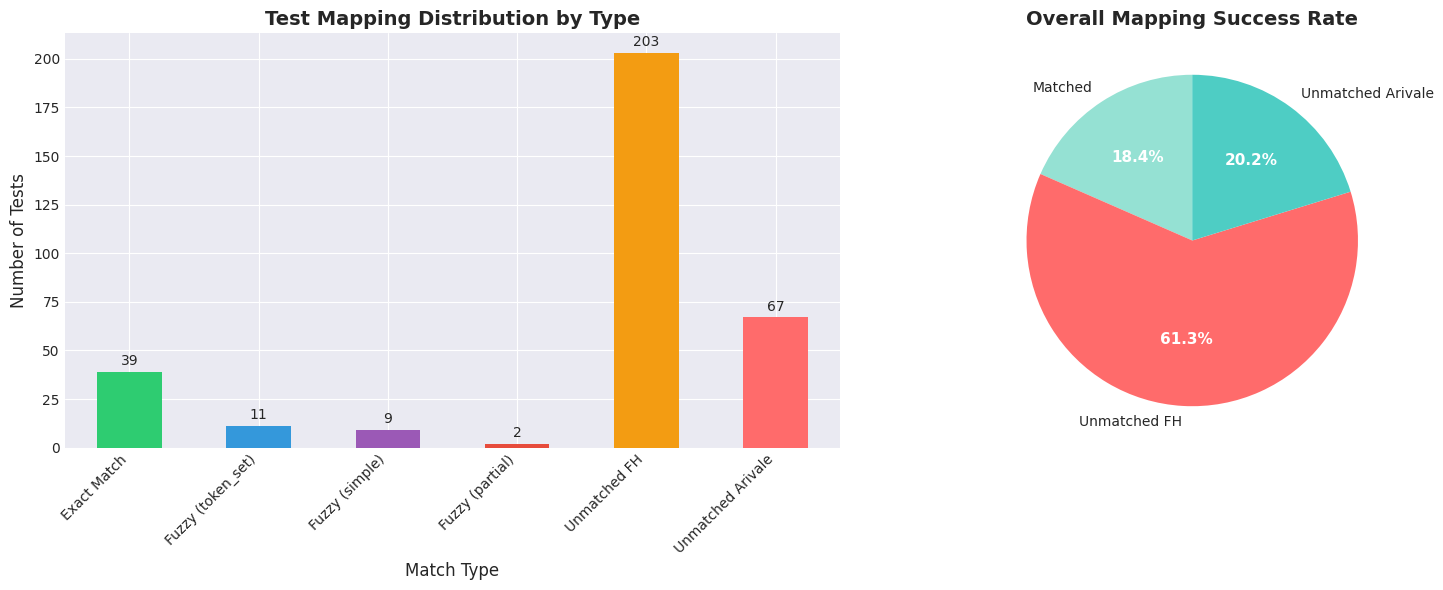


📊 Match Type Summary:
   - Exact: 39 (63.9% of matches)
   - Fuzzy (token_set_ratio): 11 (18.0% of matches)
   - Fuzzy (simple_ratio): 9 (14.8% of matches)
   - Fuzzy (partial_ratio): 2 (3.3% of matches)


In [17]:
# Create bar chart showing match type distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for match type distribution
if 'mapping_df' in locals() and not mapping_df.empty:
    match_type_counts = mapping_df['Match_Type'].value_counts()
    
    # Add unmatched counts
    unmatched_fh = len(fh_df) - len(mapping_df)
    unmatched_ar = len(arivale_df) - len(mapping_df)
    
    # Create a complete breakdown
    all_categories = pd.Series({
        'Exact Match': match_type_counts.get('Exact', 0),
        'Fuzzy (token_set)': match_type_counts.get('Fuzzy (token_set_ratio)', 0),
        'Fuzzy (simple)': match_type_counts.get('Fuzzy (simple_ratio)', 0),
        'Fuzzy (partial)': match_type_counts.get('Fuzzy (partial_ratio)', 0),
        'Manual': match_type_counts.get('Manual', 0),
        'Unmatched FH': unmatched_fh,
        'Unmatched Arivale': unmatched_ar
    })
    
    # Filter out zero values
    all_categories = all_categories[all_categories > 0]
    
    # Create color palette
    colors = ['#2ECC71', '#3498DB', '#9B59B6', '#E74C3C', '#F39C12', '#FF6B6B', '#4ECDC4']
    
    # Plot 1: Match Type Distribution
    all_categories.plot(kind='bar', ax=ax1, color=colors[:len(all_categories)])
    ax1.set_title('Test Mapping Distribution by Type', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Match Type', fontsize=12)
    ax1.set_ylabel('Number of Tests', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for i, (idx, value) in enumerate(all_categories.items()):
        ax1.text(i, value + 2, str(value), ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Pie chart for matched vs unmatched
    matched_total = len(mapping_df)
    pie_data = [matched_total, unmatched_fh, unmatched_ar]
    pie_labels = ['Matched', 'Unmatched FH', 'Unmatched Arivale']
    pie_colors = ['#95E1D3', '#FF6B6B', '#4ECDC4']
    
    # Filter out zero values
    pie_data_filtered = []
    pie_labels_filtered = []
    pie_colors_filtered = []
    for i, val in enumerate(pie_data):
        if val > 0:
            pie_data_filtered.append(val)
            pie_labels_filtered.append(pie_labels[i])
            pie_colors_filtered.append(pie_colors[i])
    
    wedges, texts, autotexts = ax2.pie(pie_data_filtered, labels=pie_labels_filtered, 
                                        colors=pie_colors_filtered, autopct='%1.1f%%',
                                        startangle=90)
    ax2.set_title('Overall Mapping Success Rate', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Match Type Summary:")
if 'mapping_df' in locals() and not mapping_df.empty:
    for match_type, count in match_type_counts.items():
        percentage = (count / len(mapping_df)) * 100
        print(f"   - {match_type}: {count} ({percentage:.1f}% of matches)")

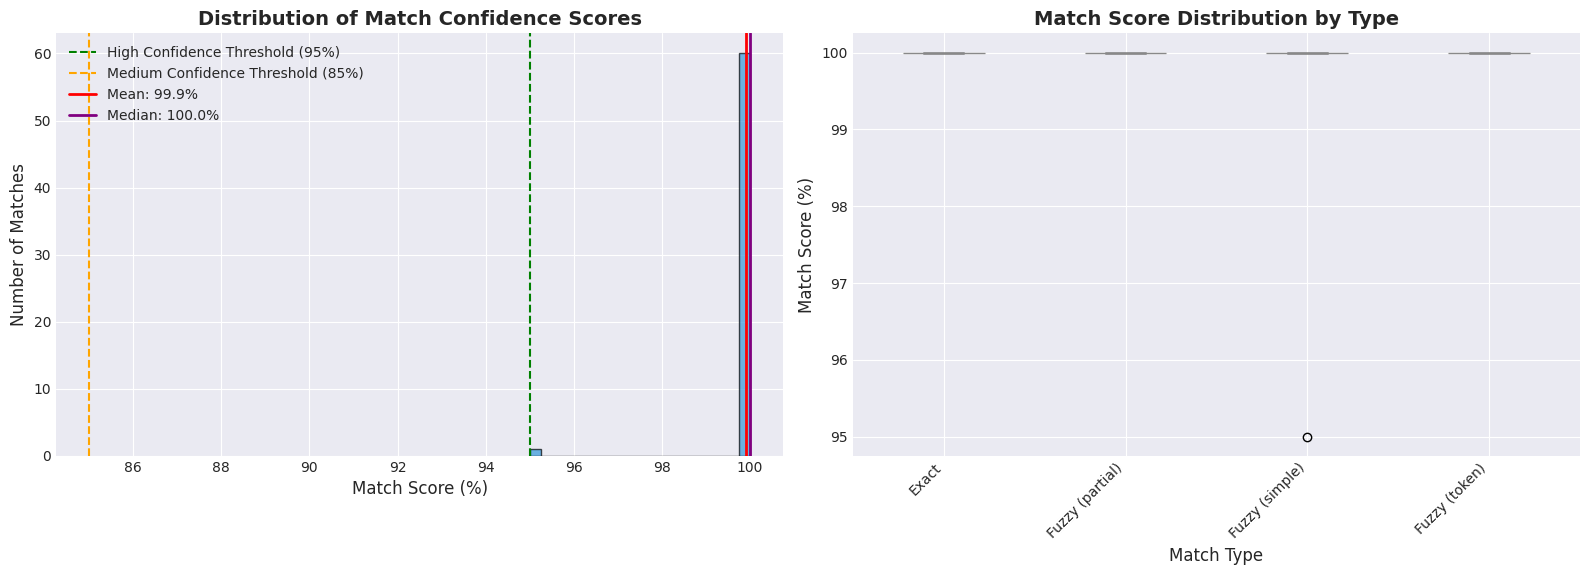


📊 Confidence Level Breakdown:
   - High confidence (≥95%): 61 matches (100.0%)
   - Medium confidence (85-94%): 0 matches (0.0%)
   - Low confidence (<85%): 0 matches (0.0%)
   - Average match score: 99.9%
   - Median match score: 100.0%


In [18]:
# Visualize match confidence scores
if 'mapping_df' in locals() and not mapping_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Histogram of match scores
    mapping_df['Match_Score'].hist(bins=20, ax=ax1, color='#3498DB', edgecolor='black', alpha=0.7)
    ax1.set_title('Distribution of Match Confidence Scores', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Match Score (%)', fontsize=12)
    ax1.set_ylabel('Number of Matches', fontsize=12)
    ax1.axvline(x=95, color='green', linestyle='--', label='High Confidence Threshold (95%)')
    ax1.axvline(x=85, color='orange', linestyle='--', label='Medium Confidence Threshold (85%)')
    ax1.legend()
    
    # Add statistics
    mean_score = mapping_df['Match_Score'].mean()
    median_score = mapping_df['Match_Score'].median()
    ax1.axvline(x=mean_score, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_score:.1f}%')
    ax1.axvline(x=median_score, color='purple', linestyle='-', linewidth=2, label=f'Median: {median_score:.1f}%')
    ax1.legend()
    
    # Plot 2: Box plot by match type
    match_types_with_scores = mapping_df[mapping_df['Match_Type'] != 'Manual'].copy()
    if not match_types_with_scores.empty:
        # Simplify match type names for better display
        match_types_with_scores['Match_Type_Simple'] = match_types_with_scores['Match_Type'].apply(
            lambda x: 'Exact' if x == 'Exact' else 
                     'Fuzzy (token)' if 'token' in x else
                     'Fuzzy (simple)' if 'simple' in x else
                     'Fuzzy (partial)'
        )
        
        # Create box plot
        match_types_with_scores.boxplot(column='Match_Score', by='Match_Type_Simple', ax=ax2)
        ax2.set_title('Match Score Distribution by Type', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Match Type', fontsize=12)
        ax2.set_ylabel('Match Score (%)', fontsize=12)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        
        # Remove the automatic title
        ax2.get_figure().suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    # Print confidence level breakdown
    print("\n📊 Confidence Level Breakdown:")
    high_conf = (mapping_df['Match_Score'] >= 95).sum()
    med_conf = ((mapping_df['Match_Score'] >= 85) & (mapping_df['Match_Score'] < 95)).sum()
    low_conf = (mapping_df['Match_Score'] < 85).sum()
    
    print(f"   - High confidence (≥95%): {high_conf} matches ({high_conf/len(mapping_df)*100:.1f}%)")
    print(f"   - Medium confidence (85-94%): {med_conf} matches ({med_conf/len(mapping_df)*100:.1f}%)")
    print(f"   - Low confidence (<85%): {low_conf} matches ({low_conf/len(mapping_df)*100:.1f}%)")
    print(f"   - Average match score: {mean_score:.1f}%")
    print(f"   - Median match score: {median_score:.1f}%")

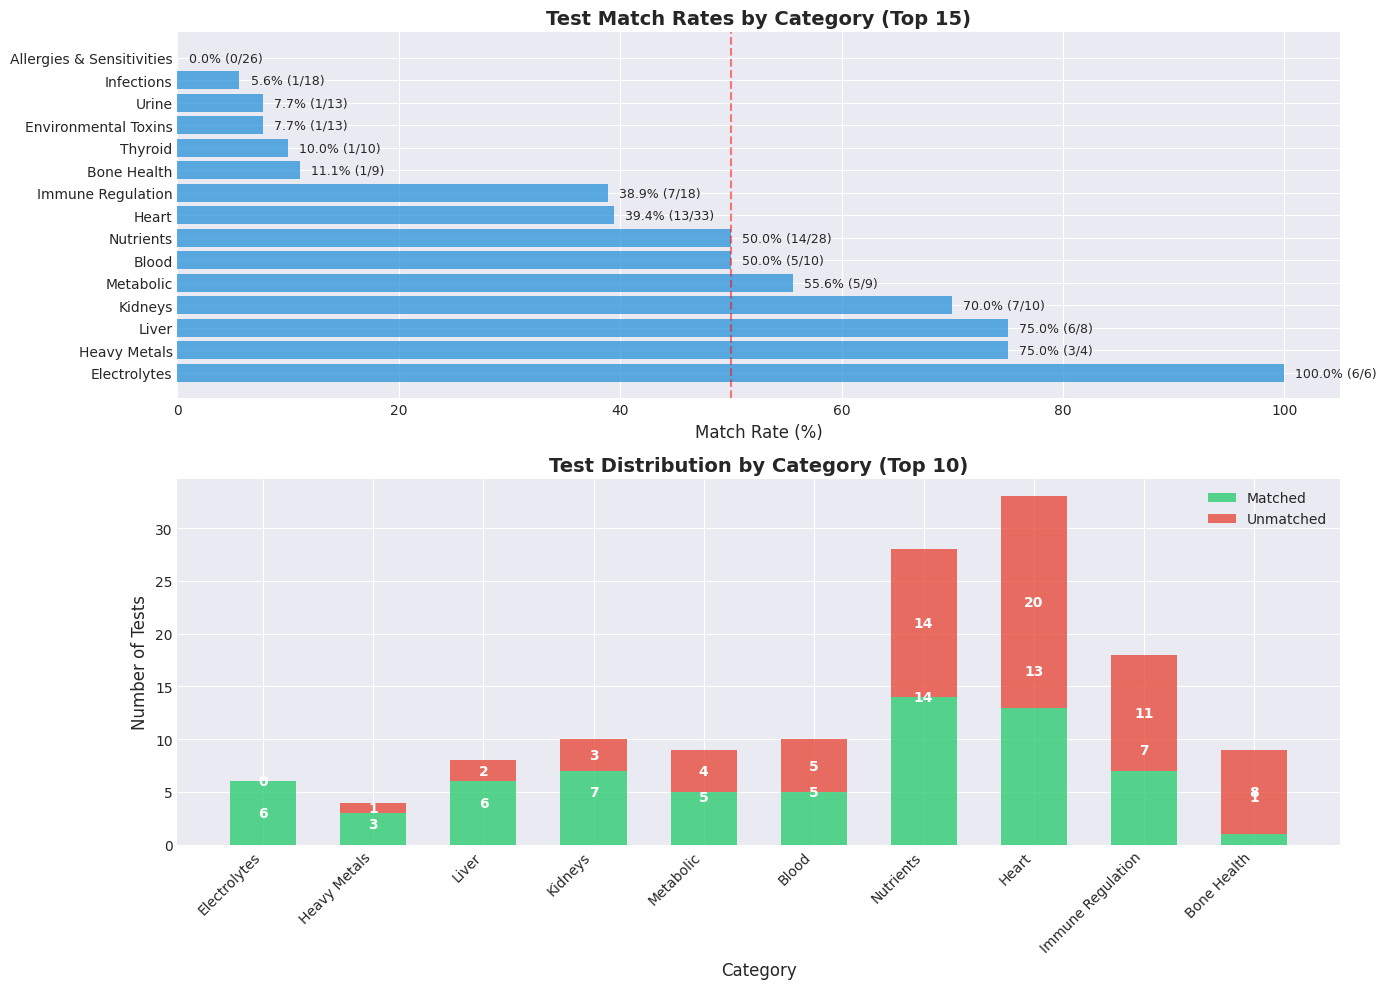


📊 Category Match Rate Analysis:

Top 5 Best Matching Categories:
   - Electrolytes: 100.0% (6/6 tests)
   - Heavy Metals: 75.0% (3/4 tests)
   - Liver: 75.0% (6/8 tests)
   - Kidneys: 70.0% (7/10 tests)
   - Metabolic: 55.6% (5/9 tests)

Bottom 5 Worst Matching Categories:
   - Female Health: 0.0% (0/14 tests)
   - Pancreas: 0.0% (0/2 tests)
   - Male Health: 0.0% (0/15 tests)
   - Stress & Aging: 0.0% (0/4 tests)
   - Sexual Health: 0.0% (0/6 tests)

Total categories analyzed: 24
Categories with 100% match rate: 1
Categories with 0% match rate: 10
Average match rate across categories: 24.8%


In [19]:
# Analyze match rates by Function Health category
if 'final_df' in locals() and not final_df.empty:
    # Split categories that have comma-separated values
    category_analysis = []
    
    for _, row in final_df[final_df['Test Name'].notna()].iterrows():
        categories = row['Category'].split(', ') if pd.notna(row['Category']) else ['Unknown']
        is_matched = pd.notna(row.get('Matched_Display_Name', None))
        
        for category in categories:
            category_analysis.append({
                'Category': category.strip(),
                'Test_Name': row['Test Name'],
                'Is_Matched': is_matched
            })
    
    category_df = pd.DataFrame(category_analysis)
    
    # Calculate match rates by category
    category_stats = category_df.groupby('Category').agg({
        'Test_Name': 'count',
        'Is_Matched': ['sum', 'mean']
    }).round(3)
    
    category_stats.columns = ['Total_Tests', 'Matched_Tests', 'Match_Rate']
    category_stats['Unmatched_Tests'] = category_stats['Total_Tests'] - category_stats['Matched_Tests']
    category_stats = category_stats.sort_values('Match_Rate', ascending=False)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Horizontal bar chart of match rates by category
    top_categories = category_stats.head(15)  # Show top 15 categories
    
    y_pos = np.arange(len(top_categories))
    matched_pct = top_categories['Match_Rate'] * 100
    
    # Create horizontal bars
    bars = ax1.barh(y_pos, matched_pct, color='#3498DB', alpha=0.8)
    
    # Add category labels
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_categories.index)
    ax1.set_xlabel('Match Rate (%)', fontsize=12)
    ax1.set_title('Test Match Rates by Category (Top 15)', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(top_categories.iterrows()):
        match_rate = row['Match_Rate'] * 100
        ax1.text(match_rate + 1, i, f'{match_rate:.1f}% ({int(row["Matched_Tests"])}/{int(row["Total_Tests"])})', 
                va='center', fontsize=9)
    
    # Add reference line at 50%
    ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.set_xlim(0, 105)
    
    # Plot 2: Stacked bar chart showing matched vs unmatched by category
    categories_for_stack = category_stats.head(10)  # Top 10 for clarity
    
    x = np.arange(len(categories_for_stack))
    width = 0.6
    
    p1 = ax2.bar(x, categories_for_stack['Matched_Tests'], width, 
                 label='Matched', color='#2ECC71', alpha=0.8)
    p2 = ax2.bar(x, categories_for_stack['Unmatched_Tests'], width,
                 bottom=categories_for_stack['Matched_Tests'],
                 label='Unmatched', color='#E74C3C', alpha=0.8)
    
    ax2.set_xlabel('Category', fontsize=12)
    ax2.set_ylabel('Number of Tests', fontsize=12)
    ax2.set_title('Test Distribution by Category (Top 10)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories_for_stack.index, rotation=45, ha='right')
    ax2.legend()
    
    # Add value labels
    for i, (idx, row) in enumerate(categories_for_stack.iterrows()):
        total = row['Total_Tests']
        matched = row['Matched_Tests']
        ax2.text(i, total/2, f'{int(matched)}', ha='center', va='center', 
                color='white', fontweight='bold')
        ax2.text(i, matched + (total-matched)/2, f'{int(total-matched)}', 
                ha='center', va='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print category statistics
    print("\n📊 Category Match Rate Analysis:")
    print("\nTop 5 Best Matching Categories:")
    for idx, row in category_stats.head(5).iterrows():
        print(f"   - {idx}: {row['Match_Rate']*100:.1f}% ({int(row['Matched_Tests'])}/{int(row['Total_Tests'])} tests)")
    
    print("\nBottom 5 Worst Matching Categories:")
    for idx, row in category_stats.tail(5).iterrows():
        print(f"   - {idx}: {row['Match_Rate']*100:.1f}% ({int(row['Matched_Tests'])}/{int(row['Total_Tests'])} tests)")
    
    # Overall category statistics
    print(f"\nTotal categories analyzed: {len(category_stats)}")
    print(f"Categories with 100% match rate: {(category_stats['Match_Rate'] == 1.0).sum()}")
    print(f"Categories with 0% match rate: {(category_stats['Match_Rate'] == 0.0).sum()}")
    print(f"Average match rate across categories: {category_stats['Match_Rate'].mean()*100:.1f}%")

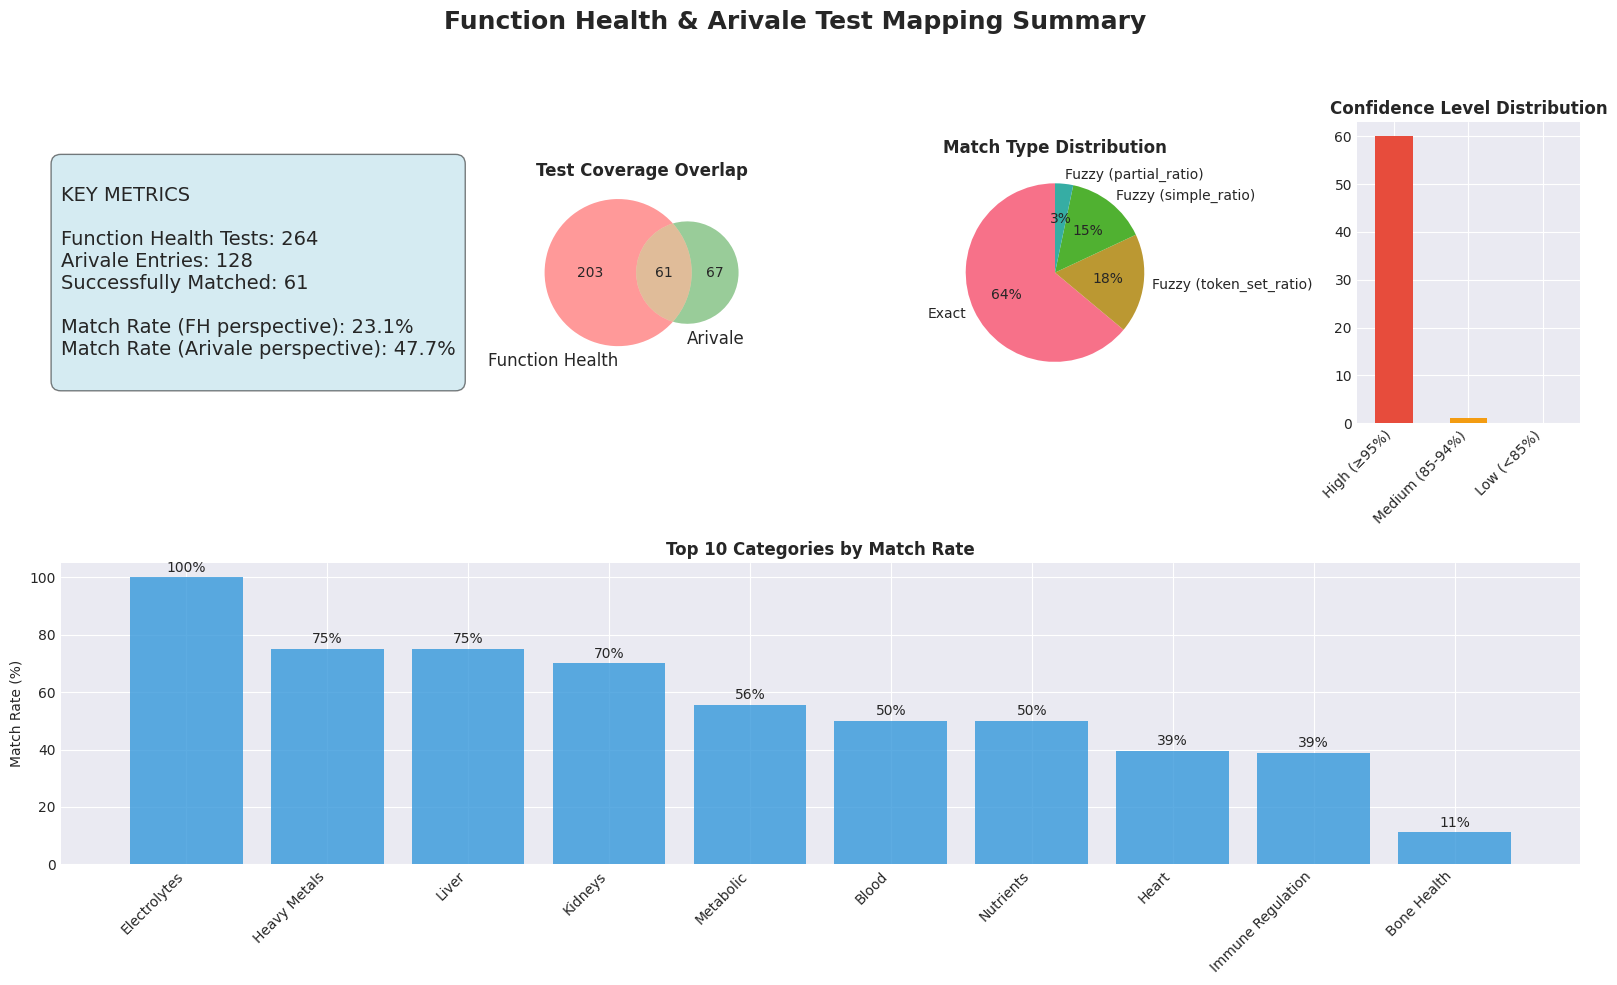


EXECUTIVE SUMMARY

✅ Successfully mapped 61 tests between Function Health and Arivale
📊 This represents 23.1% of Function Health tests
📊 And 47.7% of Arivale entries

🎯 Match Quality:
   - Exact matches: 39 (63.9%)
   - Fuzzy matches: 22 (36.1%)
   - Average confidence: 99.9%

📁 Output files have been generated in: /procedure/data/local_data/MAPPING_ONTOLOGIES/function_health



In [46]:
# Create a summary dashboard
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Function Health & Arivale Test Mapping Summary\n\n', fontsize=18, fontweight='bold')

# Define grid
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1.25, 1, 1, 1])

# Calculate key metrics
total_fh = len(fh_df)
total_ar = len(arivale_df)
total_matches = len(mapping_df) if 'mapping_df' in locals() else 0
match_rate_fh = (total_matches / total_fh * 100) if total_fh > 0 else 0
match_rate_ar = (total_matches / total_ar * 100) if total_ar > 0 else 0

# 1. Key Metrics (top row)
ax_metrics = fig.add_subplot(gs[0, 0])
ax_metrics.axis('off')

metrics_text = f"""
KEY METRICS

Function Health Tests: {total_fh}
Arivale Entries: {total_ar}
Successfully Matched: {total_matches}

Match Rate (FH perspective): {match_rate_fh:.1f}%
Match Rate (Arivale perspective): {match_rate_ar:.1f}%
"""

ax_metrics.text(0, 0.5, metrics_text, fontsize=14, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.5))

# 2. Small Venn Diagram
ax_venn = fig.add_subplot(gs[0, 1])
venn2(subsets=(total_fh - total_matches, total_ar - total_matches, total_matches), 
      set_labels=('Function Health', 'Arivale'), ax=ax_venn)
ax_venn.set_title('Test Coverage Overlap', fontsize=12, fontweight='bold')

# 3. Match Type Distribution
ax_types = fig.add_subplot(gs[0, 2])
if 'mapping_df' in locals() and not mapping_df.empty:
    match_types = mapping_df['Match_Type'].value_counts()
    match_types.plot(kind='pie', ax=ax_types, autopct='%1.0f%%', startangle=90)
    ax_types.set_ylabel('')
    ax_types.set_title('Match Type Distribution', fontsize=12, fontweight='bold')

# 4. Confidence Score Distribution
ax_conf = fig.add_subplot(gs[0, 3])
if 'mapping_df' in locals() and not mapping_df.empty:
    confidence_bins = pd.cut(mapping_df['Match_Score'], 
                            bins=[0, 85, 95, 100], 
                            labels=['Low (<85%)', 'Medium (85-94%)', 'High (≥95%)'])
    confidence_counts = confidence_bins.value_counts()
    colors = ['#E74C3C', '#F39C12', '#2ECC71']
    confidence_counts.plot(kind='bar', ax=ax_conf, color=colors)
    ax_conf.set_title('Confidence Level Distribution', fontsize=12, fontweight='bold')
    ax_conf.set_xlabel('')
    ax_conf.set_xticklabels(ax_conf.get_xticklabels(), rotation=45, ha='right')

# 5. Top Categories by Match Rate
ax_cat = fig.add_subplot(gs[1, :])
if 'category_stats' in locals():
    top_5_categories = category_stats.head(10)
    x_pos = np.arange(len(top_5_categories))
    bars = ax_cat.bar(x_pos, top_5_categories['Match_Rate'] * 100, color='#3498DB', alpha=0.8)
    ax_cat.set_xticks(x_pos)
    ax_cat.set_xticklabels(top_5_categories.index, rotation=45, ha='right')
    ax_cat.set_ylabel('Match Rate (%)', fontsize=10)
    ax_cat.set_title('Top 10 Categories by Match Rate', fontsize=12, fontweight='bold')
    ax_cat.set_ylim(0, 105)
    
    # Add value labels
    for i, (idx, val) in enumerate(top_5_categories['Match_Rate'].items()):
        ax_cat.text(i, val * 100 + 1, f'{val*100:.0f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print executive summary
print("\n" + "="*60)
print("EXECUTIVE SUMMARY")
print("="*60)
print(f"\n✅ Successfully mapped {total_matches} tests between Function Health and Arivale")
print(f"📊 This represents {match_rate_fh:.1f}% of Function Health tests")
print(f"📊 And {match_rate_ar:.1f}% of Arivale entries")

if 'mapping_df' in locals() and not mapping_df.empty:
    exact_matches = (mapping_df['Match_Type'] == 'Exact').sum()
    fuzzy_matches = total_matches - exact_matches
    avg_confidence = mapping_df['Match_Score'].mean()
    
    print(f"\n🎯 Match Quality:")
    print(f"   - Exact matches: {exact_matches} ({exact_matches/total_matches*100:.1f}%)")
    print(f"   - Fuzzy matches: {fuzzy_matches} ({fuzzy_matches/total_matches*100:.1f}%)")
    print(f"   - Average confidence: {avg_confidence:.1f}%")

print(f"\n📁 Output files have been generated in: {fh_csv_path.parent}")
print("\n" + "="*60)